In [1]:
# importing required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [2]:
def ordinary_kriging(a, b, prop, range_, sill, nugget, loc_smooth):
    '''
    Ordinary kriging interpolation for single point.
    
    Parameters:
        a (numpy.array): distance vector between target point and input data locations
        b (numpy.array): distance matrix between input data locations
        prop (numpy.array): property values at input data locations
        range_ (float): range parameter of model
        sill (float): sill parameter of model
        nugget (float): nugget parameter of model
        loc_smooth (numpy.array): local smoothing per input data point
        
    Return:
        result (float): calculated semivariances
        pred_var (float):
        w (numpy.array): set of calculated kriging weights
    '''
    
    # empty matrix building for OK
    shape = len(a)
    C = np.zeros((shape + 1, shape + 1))
    c = np.zeros((shape + 1))
    w = np.zeros((shape + 1))

    # filling matrices based on model for spatial correlation
    C[:shape, :shape] = exponential_variogram_model(b, range_, sill, nugget)
    c[:shape] = exponential_variogram_model(a, range_, sill, nugget)
    
    # local smoothing
    np.fill_diagonal(C, loc_smooth)
    
    # matrix setup for OK
    C[shape, :] = 1.0
    C[:, shape] = 1.0
    C[shape, shape] = 0.0
    c[shape] = 1.0

    # Solve Kriging equations
    w = np.linalg.solve(C, c)
    
    # calculating estimate and variance for kriging
    pred_var = w[shape] + np.sum(w[:shape] * c[:shape])
    result = np.dot(prop, w[:shape])
    
    return result, pred_var, w

def exponential_variogram_model(d, range_, sill, nugget):
    '''
    Exponential variogram function.
    
    Parameters:
        d (numpy.array): lag distances
        range_ (float): range parameter of model
        sill (float): sill parameter of model
        nugget (float): nugget parameter of model
        
    Return:
        gamma (numpy.array): calculated semivariances
    '''
    # calculate partial sill
    psill = sill - nugget 
    
    # semivariance for exponential model
    gamma = psill * (1. - np.exp(-d / (range_))) + nugget
    
    return gamma

In [3]:
# Set a set of  input data

# set x values
x_pos = np.arange(1,10,1).reshape(9,1)

# set y values 
y_val = np.array([8, 2, 2, 7, 5, 1, 9, 1,7])

# set grid to interpolate
grid_x = np.arange(0,10,0.01).reshape(1000,1)

In [4]:
# precalculate distance matrices
dist_all_to_all = cdist(x_pos, x_pos)
dist_target_to_all = cdist(grid_x, x_pos)

In [5]:
# empty container for results
result1 = np.zeros((1000))
result2 = np.zeros((1000))
result3 = np.zeros((1000))

# set sill, range and original nugget
range_ = 0.2
sill = 1
nugget = 0

# calculate set of results based on varying nugget settings
for i in range(len(grid_x)):
    
    # zero local smoothing
    test_res1, test_var, w = ordinary_kriging(dist_target_to_all[i], 
                                             dist_all_to_all, y_val, 
                                             range_, sill, nugget, np.zeros(9))
    result1[i]=test_res1

    # manually fixed  local smoothing
    test_res2, test_var, w = ordinary_kriging(dist_target_to_all[i], 
                                             dist_all_to_all, y_val, 
                                             range_, sill, nugget, np.array([0, -1,-1,0,0,-1,-1,0,0]))
    result2[i]=test_res2

    # gradually increasing local smoothing
    test_res3, test_var, w = ordinary_kriging(dist_target_to_all[i], 
                                             dist_all_to_all, y_val, 
                                             range_, sill, nugget, np.arange(0,1.8,0.2)*(-1))
    result3[i]=test_res3

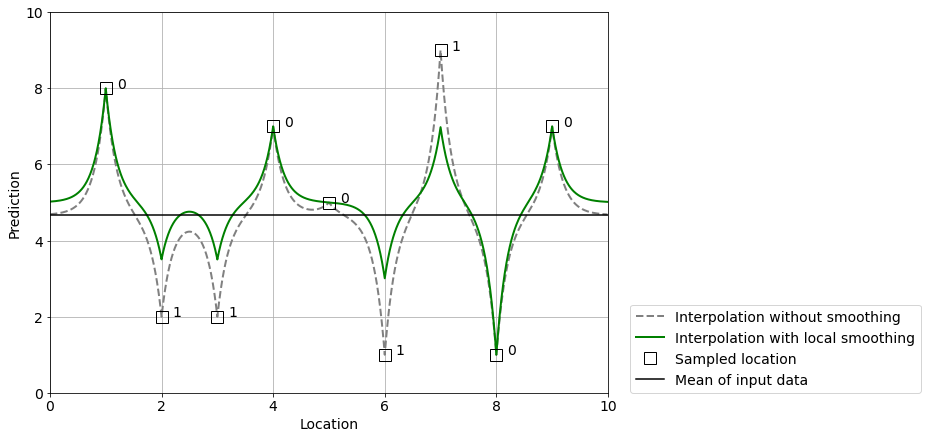

In [6]:
# Create figure 4 (a)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

axes.plot(grid_x[:,0], result1, label="Interpolation without smoothing", color="grey", linewidth=2, linestyle='--')
axes.plot(grid_x[:,0], result2, label="Interpolation with local smoothing", color="green", linewidth=2)

axes.plot(x_pos, y_val, 's', markersize=12, fillstyle='none', color='black', label='Sampled location')
#axes.plot(x_pos, y_val, 'o', markersize=9, color='black')

n = np.array([0, -1,-1,0,0,-1,-1,0,0])*(-1)
for i, txt in enumerate(n):
    axes.annotate(txt, (x_pos[i]+0.2, y_val[i]), fontsize=14)

axes.plot([0,10], [np.mean(y_val), np.mean(y_val)], label="Mean of input data", color="black")
axes.set_ylim(0,10)
axes.set_xlim(0,10)
axes.set_ylabel("Prediction", fontsize=14)
axes.set_xlabel("Location",fontsize=14)
#plt.title("1D Example - Local smoothing")

axes.legend(loc=(1.04,0), fontsize=14)
axes.grid()
axes.tick_params(axis='x', labelsize=14)
axes.tick_params(axis='y', labelsize=14)

plt.savefig("Loc_smooth_fix.png")

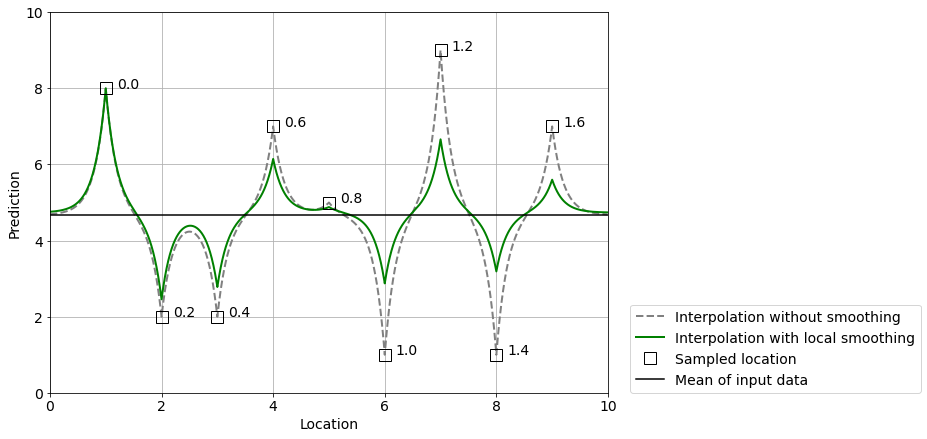

In [7]:
# Create figure 4 (b)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

axes.plot(grid_x[:,0], result1, label="Interpolation without smoothing", color="grey", linewidth=2, linestyle='--')
axes.plot(grid_x[:,0], result3, label="Interpolation with local smoothing", color="green", linewidth=2)

axes.plot(x_pos, y_val, 's', markersize=12, fillstyle='none', color='black', label='Sampled location')
#axes.plot(x_pos, y_val, 'o', markersize=9, color='black')

n = np.arange(0,1.8,0.2)
for i, txt in enumerate(n):
    axes.annotate(np.round(txt,1), (x_pos[i]+0.2, y_val[i]), fontsize=14)

axes.plot([0,10], [np.mean(y_val), np.mean(y_val)], label="Mean of input data", color="black")
axes.set_ylim(0,10)
axes.set_xlim(0,10)
axes.set_ylabel("Prediction", fontsize=14)
axes.set_xlabel("Location", fontsize=14)
#plt.title("1D Example - Local smoothing")
axes.legend(loc=(1.04,0), fontsize=14)
axes.grid()
axes.tick_params(axis='x', labelsize=14)
axes.tick_params(axis='y', labelsize=14)

plt.savefig("Loc_smooth_grad.png")